# Optimization model

---
Import the libraries

In [1]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dataset

---
Step 1: Import the dataset (input.xlsx)

In [2]:
data = pd.read_excel('input.xlsx', None)

Setp 2: Assign the dataset into respective variables

In [3]:
T_start = data['Dataset']['Trip Begin'].tolist()
T_start = [int(x) for x in T_start]
T_end = data['Dataset']['Trip End'].tolist()
T_end = [int(x) for x in T_end]
alpha = data['Dataset']['Charger'].tolist()
gama = data['Dataset']['Energy consumption'].tolist()
gama = gama[0]
C_bat = data['Dataset']['Buses'].tolist()
P = data['Energy Price']['Buy']
ch_eff = 0.9
E_0 = 0.2
E_max = 1
E_min = 0.2
E_end = 0.2
delta_t = 0.25
T = 96
t = len(P)
k = len(C_bat)
n = len(alpha)
i = len(T_start)

## Programming the Opt model

---

### Step 1: Define the model

In [4]:
model = pyo.ConcreteModel()

### Step 2: Define the ranges

In [5]:
#ranges
model.I = pyo.RangeSet(i) # set of trips
model.T = pyo.RangeSet(t) # set of timesteps
model.K = pyo.RangeSet(k) # set of buses
model.N = pyo.RangeSet(n) # set of chargers

### Step 3: Define the parameters

In [6]:
#parameters
model.T_start = pyo.Param(model.I, initialize=lambda model, i: T_start[i-1]) # start time of trip i
model.T_end = pyo.Param(model.I, initialize=lambda model, i: T_end[i-1]) # end time of trip i
model.alpha = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # charging power of charger n
model.ch_eff = pyo.Param(initialize=ch_eff) # charging efficiency of charger n
model.gama = pyo.Param(initialize=gama) # energy consumption
model.P = pyo.Param(model.T, initialize=lambda model, t: P[t-1]) # electricity purchasing price in time t
model.E_0 = pyo.Param(initialize=E_0) # initial energy level of bus k
model.E_min = pyo.Param(initialize=E_min) # minimum energy level allowed for bus k
model.E_max = pyo.Param(initialize=E_max) # maximum energy level allowed for bus k
model.E_end = pyo.Param(initialize=E_end) # minimum energy after an operation day for bus k
model.C_bat = pyo.Param(model.K, initialize=lambda model, k: C_bat[k-1]) # total capacity of the bus k battery

### Step 4: Define the variables

In [7]:
#binary variables
model.b = pyo.Var(model.K,model.I, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
model.x = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
model.c = pyo.Var(model.K, model.T, domain=pyo.Binary) # binary variable indicating if bus k is charging/discharging at time t

#non-negative variables
model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t

### Step 5: Define the objective function

In [8]:
#objective function
def rule_obj(mod):
    return sum(mod.P[t]*mod.w_buy[t] for t in mod.T)
model.obj = pyo.Objective(rule=rule_obj, sense=pyo.minimize)

#### Step 6: Define the constraints

In [9]:
#constraints
model.constraints = pyo.ConstraintList()  # Create a set of constraints

#constraint 1
for k in model.K:
    for t in model.T:
        model.constraints.add(sum(model.b[k,i,t] for i in model.I) + sum(model.x[k,n,t] for n in model.N) <=1)

#constraint 2
for n in model.N:
    for t in model.T:
        model.constraints.add(sum(model.x[k,n,t] for k in model.K) <= 1)

#constraint 3
for i in model.I: 
    for t in range(model.T_start[i],model.T_end[i]):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 1)

    for t in range(1,model.T_start[i]):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 0)

    for t in range(model.T_end[i],T+1):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 0)

#constraint 4
for i in model.I:
    for k in model.K:
        for t in range(model.T_start[i],model.T_end[i]-1):
            model.constraints.add(model.b[k,i,t+1] >= model.b[k,i,t])

#constraint 5
for k in model.K:
    for t in range(2,T+1):
        model.constraints.add(model.e[k,t] == model.e[k,t-1] + sum(delta_t * model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N) - sum(model.gama * model.b[k,i,t] for i in model.I))

#constraint 6
for t in model.T:
    model.constraints.add(sum(delta_t * model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) == model.w_buy[t])

#constraint 7
for k in model.K:
    for t in model.T:
        model.constraints.add(model.e[k,t] >= model.C_bat[k] * model.E_min)

#constraint 8
for k in model.K:
    for t in model.T:
        model.constraints.add(E_max * model.C_bat[k] >= model.e[k,t])          

#constraint 9
for k in model.K:
    model.constraints.add(model.e[k,1] == model.E_0*model.C_bat[k])

#constraint 10
for k in model.K:
    model.constraints.add(model.e[k,T] >= model.E_end*model.C_bat[k])  

### Step 7: Solve the model

In [10]:
opt = pyo.SolverFactory('gurobi')
#opt.options['timelimit'] = 60
#opt.options['mipgap'] = 0.01
results = opt.solve(model,tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-29
Read LP format model from file /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmp_xk0zjt9.pyomo.lp
Reading time = 0.07 seconds
x1: 11326 rows, 20256 columns, 81856 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11326 rows, 20256 columns and 81856 nonzeros
Model fingerprint: 0xaf82794e
Variable types: 1056 continuous, 19200 integer (19200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 8816 rows and 10526 columns
Presolve time: 0.34s
Presolved: 2510 rows, 9730 columns, 39270 nonzeros
Variable types: 0 continuous, 9730 integer (9010 binary)

Root relaxation: objective 4.492927e+01, 1860 iterations, 0.07 seconds 

## Results and Vizualization

---

In [11]:
print('The objective function values is:', model.obj())
print(results)

The objective function values is: 54.545425749318824

Problem: 
- Name: x1
  Lower bound: 54.545425749318795
  Upper bound: 54.545425749318824
  Number of objectives: 1
  Number of constraints: 11326
  Number of variables: 20256
  Number of binary variables: 19200
  Number of integer variables: 19200
  Number of continuous variables: 1056
  Number of nonzeros: 81856
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 1.5439910888671875
  Error rc: 0
  Time: 1.8043019771575928
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Plotting and assessing the results

Defining the plot functions

In [12]:
def plot_energy(K,T,e):
    bus_list = []
    energy_list = []
    for k in K:
        bus_number = 'bus' + ' ' + str(k)
        bus_list.append(bus_number)
    for t in T:
        for  k in K:
            energy_list.append(pyo.value(e[k,t]))
    energy_array = np.reshape(energy_list, (len(T), len(bus_list)))
    Energy = pd.DataFrame(energy_array,index=T, columns=bus_list)
    Energy_perc = (Energy*100)/C_bat[0]
    Energy_perc.plot(figsize=(12,6))
    plt.xlabel('Time [min]')
    plt.ylabel('State of Charge [%]')
    return Energy, Energy_perc

def plot_power(T,w):
    transac_list = []
    for t in T:
        value = pyo.value(w[t])
        transac_list.append(value)
    Power = pd.DataFrame(transac_list, index=T, columns=['Power'])*4
    Power.plot(figsize=(12,6))
    plt.xlabel('Time [min]')
    plt.ylabel('Power [kWh]')
    return Power

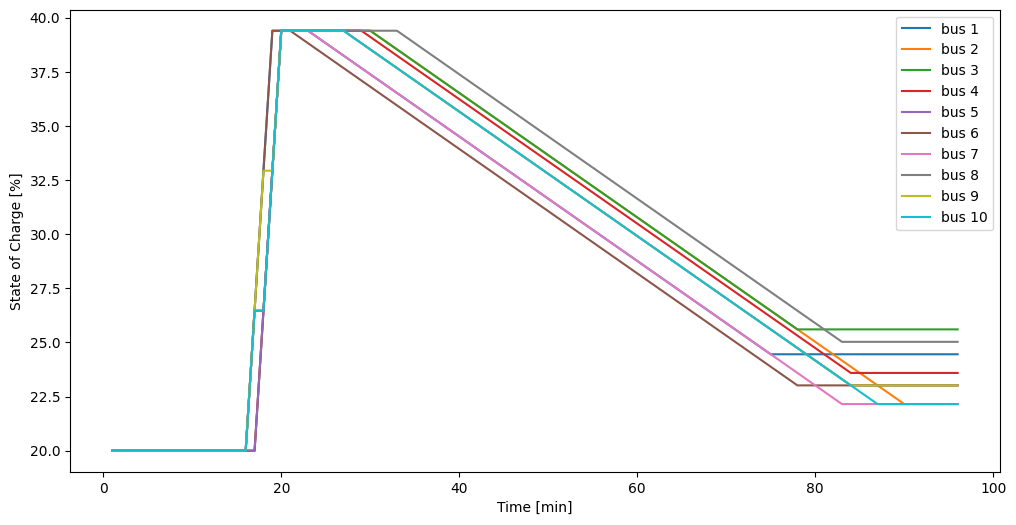

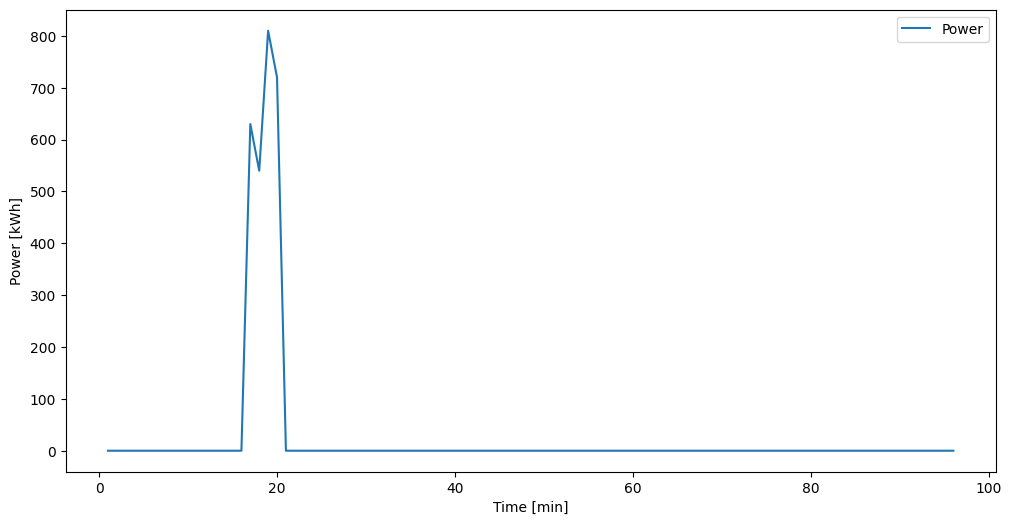

In [13]:
energy, energy_perc = plot_energy(model.K,model.T,model.e)
power = plot_power(model.T,model.w_buy)


In [14]:
energy.describe()

,bus 1,bus 2,bus 3,bus 4,bus 5,bus 6,bus 7,bus 8,bus 9,bus 10
count,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,99.417708,101.865625,103.19375,101.527083,100.100000,97.240625,97.490625,104.626042,100.568750,99.990625
std,21.552765,23.772159,22.73848,23.347713,23.150878,21.705287,22.349285,23.315611,22.981779,23.275038
min,69.600000,69.600000,69.60000,69.600000,69.600000,69.600000,69.600000,69.600000,69.600000,69.600000
25%,85.100000,78.850000,89.10000,82.100000,80.100000,80.100000,77.100000,87.100000,80.100000,77.100000
50%,94.600000,100.600000,100.60000,99.600000,97.600000,92.600000,93.600000,103.600000,98.600000,97.600000
75%,117.350000,123.350000,123.35000,122.350000,120.350000,115.350000,116.350000,126.350000,120.350000,120.350000
max,137.100000,137.100000,137.10000,137.100000,137.100000,137.100000,137.100000,137.100000,137.100000,137.100000


In [15]:
energy_perc.describe()

,bus 1,bus 2,bus 3,bus 4,bus 5,bus 6,bus 7,bus 8,bus 9,bus 10
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,28.568307,29.271731,29.653376,29.174449,28.764368,27.942708,28.014547,30.064955,28.899066,28.732938
std,6.193323,6.831080,6.534046,6.709113,6.652551,6.237151,6.422208,6.699888,6.603960,6.688229
min,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
25%,24.454023,22.658046,25.603448,23.591954,23.017241,23.017241,22.155172,25.028736,23.017241,22.155172
50%,27.183908,28.908046,28.908046,28.620690,28.045977,26.609195,26.896552,29.770115,28.333333,28.045977
75%,33.721264,35.445402,35.445402,35.158046,34.583333,33.146552,33.433908,36.307471,34.583333,34.583333
max,39.396552,39.396552,39.396552,39.396552,39.396552,39.396552,39.396552,39.396552,39.396552,39.396552


In [16]:
power.describe()

,Power
count,96.000000
mean,28.125000
std,137.153871
min,0.000000
25%,-0.000000
50%,-0.000000
75%,0.000000
max,810.000000
